In [3]:
import os
import sys
sys.path.append(os.path.join(os.pardir, os.pardir, os.pardir, os.pardir))
from mwaa_dev.bin.python_shell import set_import_paths, load_environment

In [4]:
set_import_paths()
load_environment()

>>> Setting `from dags import` directory to: /Users/mitchbeebe/Desktop/irondata/mwaa_dev/dags
>>> Setting `from shared import` directory to: /Users/mitchbeebe/Desktop/irondata/mwaa_dev/dags/shared
>>> Loading env variables from: /Users/mitchbeebe/Desktop/irondata/mwaa_dev/docker/config/.env.localrunner


In [5]:
from datetime import datetime
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.serialize import model_to_json

from ironpy.analytics import DB

Importing plotly failed. Interactive plots will not work.


In [6]:
db = DB()
df = db.run("""
    SELECT 
        application_submission_date::DATE AS ds
        , COUNT(DISTINCT application_id)::FLOAT AS y
    FROM fis.admissions
    WHERE 
        application_submission_date BETWEEN '2020-01-01' AND CURRENT_DATE
        AND (
            email !~* '(mrkt)|(flatironschool)|(qq\\.com)'
            AND NVL(application_coupon_code, 'null') != 'DELOITTE'
            AND NVL(application_coupon_code, 'null') != 'BLKROCK'
            AND NVL(application_coupon_code, 'null') != 'DELOITTECLOUD'
            AND NVL(application_coupon_code, 'null') != '2023AMZNCC'
        )
    GROUP BY 1
    """)

m = Prophet()
m.fit(df)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -5.48587
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      85       2922.74   0.000198637       144.601   1.909e-06       0.001      144  LS failed, Hessian reset 
      99       2923.09    0.00069007       106.667           1           1      162   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     152       2923.78    0.00020933       78.9143   3.053e-06       0.001      257  LS failed, Hessian reset 
     199       2923.83    1.8829e-06        57.901      0.5071      0.5071      320   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     218       2923.83   2.09566e-05       69.7514   3.048e-07       0.001      378  LS failed, Hessian reset 
     239       2923.83   1.36106e-07       45.5357      0.9656      0.9656      407   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is

In [7]:
df_cv = cross_validation(
    m, 
    initial='730 days', 
    period='7 days', 
    horizon = '42 days')

INFO:prophet:Making 58 forecasts with cutoffs between 2022-01-05 00:00:00 and 2023-02-08 00:00:00


  0%|          | 0/58 [00:00<?, ?it/s]

Initial log joint probability = -6.34464
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1802.27   7.42064e-06       62.0791           1           1      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1803.27    0.00031298       69.3828           1           1      265   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     213       1803.33   4.48395e-05        57.309   7.701e-07       0.001      326  LS failed, Hessian reset 
     299       1803.41   8.27569e-06       94.1004           1           1      434   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     326       1803.41   8.76612e-08       71.7198      0.3177           1      479   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probabil

In [8]:
df_p = performance_metrics(df_cv)
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,5 days,646.570735,25.427755,17.756463,0.198165,0.157840,0.183766,0.872641
1,6 days,598.079535,24.455665,17.973373,0.194897,0.155017,0.181532,0.857954
2,7 days,676.814715,26.015663,19.539879,0.190602,0.146761,0.179793,0.823258
3,8 days,759.457286,27.558253,20.037950,0.172472,0.122259,0.167243,0.819143
4,9 days,849.734650,29.150208,20.198944,0.177015,0.114822,0.169168,0.817795
5,10 days,789.728019,28.102100,19.059668,0.185004,0.120451,0.175099,0.835036
6,11 days,706.724916,26.584298,18.041756,0.203755,0.141053,0.187230,0.865617
7,12 days,756.143997,27.498073,19.203456,0.213827,0.163610,0.197823,0.843054
8,13 days,701.453586,26.484969,19.547941,0.211119,0.163610,0.196255,0.826806
9,14 days,774.570715,27.831111,21.087277,0.206199,0.154513,0.194051,0.797006


In [9]:
future = m.make_future_dataframe(periods=42)
forecast = m.predict(future)

(0.0, 200.0)

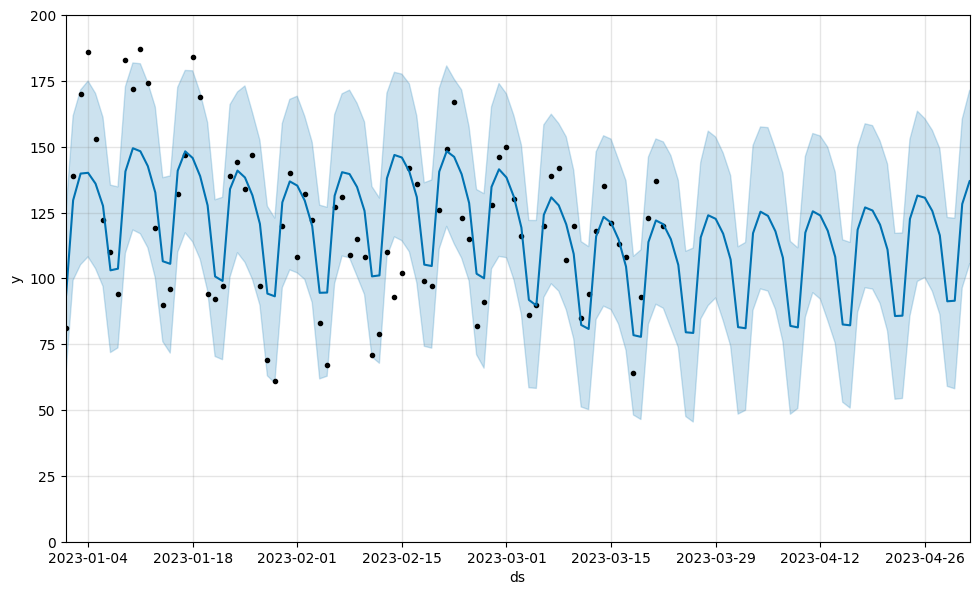

In [10]:
fig = m.plot(forecast)
fig.get_children()[1].set_xlim([datetime(2023,1,1), datetime(2023,5,2)])
fig.get_children()[1].set_ylim([0, 200])

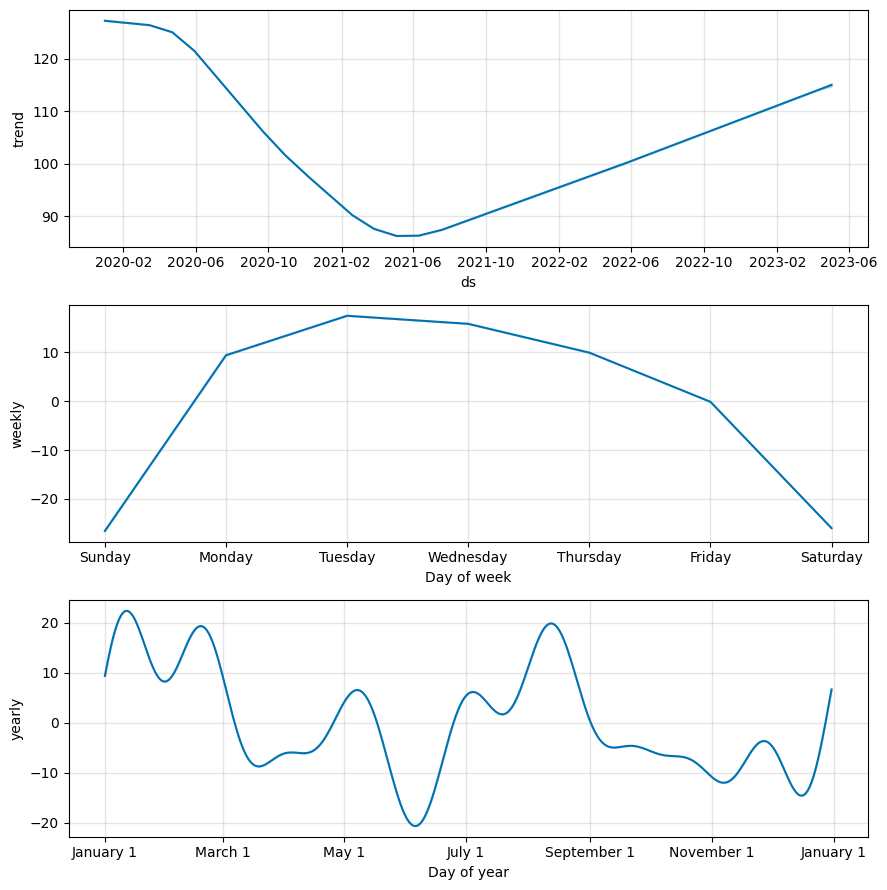

In [11]:
fig2 = m.plot_components(forecast)
# App to matriculate % and time to matriculate by month

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



Initial log joint probability = -50.7667
Iteration  1. Log joint probability =    28.6644. Improved by 79.4311.
Iteration  2. Log joint probability =      53.49. Improved by 24.8256.
Iteration  3. Log joint probability =    69.2324. Improved by 15.7424.
Iteration  4. Log joint probability =    70.4925. Improved by 1.26002.
Iteration  5. Log joint probability =     70.795. Improved by 0.302567.
Iteration  6. Log joint probability =    70.9645. Improved by 0.169489.
Iteration  7. Log joint probability =    71.1149. Improved by 0.150354.
Iteration  8. Log joint probability =    71.2363. Improved by 0.121462.
Iteration  9. Log joint probability =    71.2502. Improved by 0.0139038.
Iteration 10. Log joint probability =    71.2676. Improved by 0.0173556.
Iteration 11. Log joint probability =    71.3556. Improved by 0.0880501.
Iteration 12. Log joint probability =    71.3949. Improved by 0.0392469.
Iteration 13. Log joint probability =    71.4212. Improved by 0.0263534.
Iteration 14. Log joi

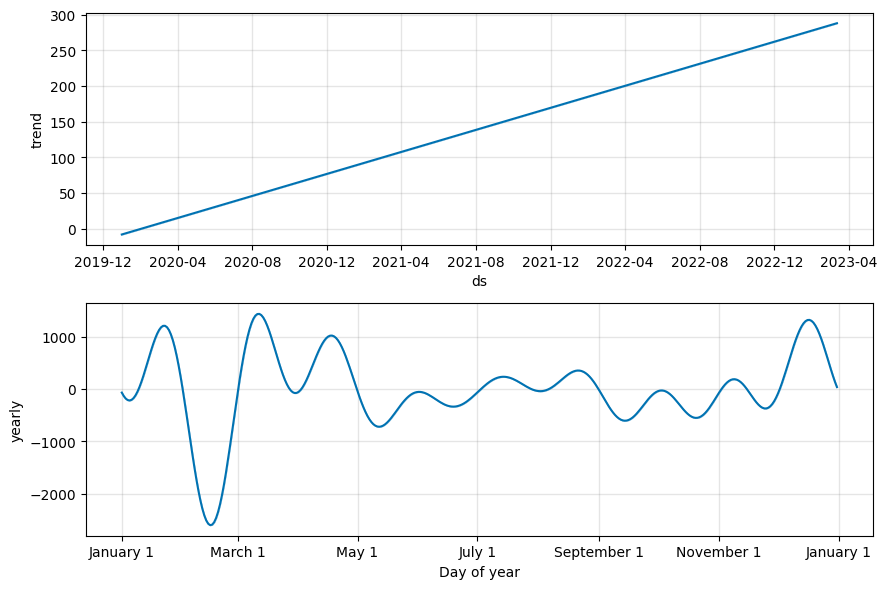

In [22]:
mdf = db.run("""
    select date_trunc('month', matriculation_date) ds
    , count(1) y 
    from fis.students 
    where matriculation_date >= '2020-01-01'
    group by 1""")
m2 = Prophet()
m2.fit(mdf)
f = m2.make_future_dataframe(periods=12)
ff = m2.predict(f)
t = m2.plot_components(ff)

In [ ]:
with open('serialized_model.json', 'w') as fout:
    fout.write(model_to_json(m))  # Save model